In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## 1. 讀入 Fashion MNSIT 數據集

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## 2. 欣賞數據集內容

**隨機查看訓練集中的五張圖片和其類別**

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

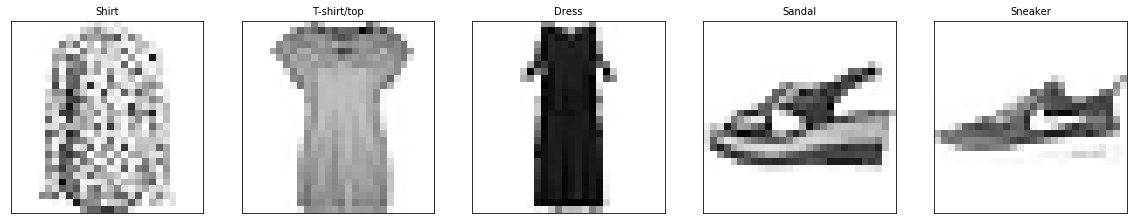

In [5]:
pick = np.random.choice(60000, 5, replace=False)
plt.figure(figsize=(20,10)) # 調整畫布的大小

for i in range(5):
    n = pick[i]
    ax = plt.subplot(151+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[y_train[n]], fontsize=10)
    plt.imshow(x_train[n], cmap='Greys')  

## 3. 資料整理

**將圖片中的像素正規化 range(0, 255) → range(0, 1)**

In [6]:
x_train = x_train / 255
x_test = x_test / 255

**CNN的輸入資料需要定義channel的數量，由於該資料集的圖片是灰階的，即一個channel(彩色圖片有三個)，因此必須將X的形狀從 (n, 28, 28) 重塑成  
(n, 28, 28, 1)，也就是將channel的數量放在X的第四個維度**

In [7]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

**對y進行獨熱編碼(one-hot encoding)**

In [8]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 4. 打造神經網路

### 4-1. 基本模型：Keras官網Mnist的cnn範例
參考網址：https://keras.io/examples/mnist_cnn/  
備註：原本範例的optimizer是用Adadelta，但後來執行程式發生錯誤，因此改用adam。

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
import keras

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.Adadelta(),
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [10]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 34s 563us/sample - loss: 0.5177 - acc: 0.8185 - val_loss: 0.3351 - val_acc: 0.8796
Epoch 2/12
60000/60000 [==============================] - 32s 528us/sample - loss: 0.3398 - acc: 0.8785 - val_loss: 0.2852 - val_acc: 0.8970
Epoch 3/12
60000/60000 [==============================] - 32s 532us/sample - loss: 0.2922 - acc: 0.8937 - val_loss: 0.2632 - val_acc: 0.9019
Epoch 4/12
60000/60000 [==============================] - 37s 620us/sample - loss: 0.2610 - acc: 0.9053 - val_loss: 0.2387 - val_acc: 0.9126
Epoch 5/12
60000/60000 [==============================] - 37s 612us/sample - loss: 0.2358 - acc: 0.9141 - val_loss: 0.2259 - val_acc: 0.9169
Epoch 6/12
60000/60000 [==============================] - 41s 676us/sample - loss: 0.2132 - acc: 0.9213 - val_loss: 0.2223 - val_acc: 0.9198
Epoch 7/12
60000/60000 [==============================] - 37s 612us/sample - loss: 0.1988 - acc: 0.9271 

### 4-2. 使用Functional API實作的模型

以下為我設計的模型架構，由於透過Functional API可以使訓練的過程分歧之後再合併，因此訓練的過程中，**卷積層我一邊使用relu作為激活函數(branch1)，另一邊則使用sigmoid(branch2)**，再將兩邊的結果合併起來之後做maxpooling。另外，我用**平均最大池化層(average pooling layer)**取代扁平層(flatten layer)，減少模型的訓練參數，讓模型的訓練過程更有效率。

備註：模型架構圖的畫法有附在該程式最下方「補充：模型視覺化」的地方

<img src="model_structure_1.png" height="50%" width="50%">

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate, add

keras.backend.clear_session() # 清除之前的模型

img_input = Input(shape=(28,28,1), name='iamge_input')

### convolutional block 1 ###
branch1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_branch1_conv1')(img_input)
branch1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_branch1_conv2')(branch1)

branch2 = Conv2D(32, (3, 3), padding='same', activation='sigmoid', name='block1_branch2_conv1')(img_input)
branch2 = Conv2D(32, (3, 3), padding='same', activation='sigmoid', name='block1_branch2_conv2')(branch2)

out = concatenate([branch1, branch2], name='block1_concatenate')

out = MaxPooling2D(pool_size=(2, 2), name='block1_MaxPooling2D')(out)

### convolutional block 2 ###
branch1 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_branch1_conv1')(out)
branch1 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_branch1_conv2')(branch1)

branch2 = Conv2D(64, (3, 3), padding='same', activation='sigmoid', name='block2_branch2_conv1')(out)
branch2 = Conv2D(64, (3, 3), padding='same', activation='sigmoid', name='block2_branch2_conv2')(branch2)

out = concatenate([branch1, branch2], name='block2_concatenate')

out = GlobalAveragePooling2D(name='block2_GlobalAveragePooling2D')(out)

### fully-connected layer as a classfier ###
out = Dense(10, activation='softmax')(out)

model = Model(img_input, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
iamge_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
block1_branch1_conv1 (Conv2D)   (None, 28, 28, 32)   320         iamge_input[0][0]                
__________________________________________________________________________________________________
block1_branch2_conv1 (Conv2D)   (None, 28, 28, 32)   320         iamge_input[0][0]                
__________________________________________________________________________________________________
block1_branch1_conv2 (Conv2D)   (None, 28, 28, 32)   9248        block1_branch1_conv1[0][0]       
______________________________________________________________________________________________

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.Adadelta(),
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 79s 1ms/sample - loss: 1.0157 - acc: 0.6253 - val_loss: 0.6613 - val_acc: 0.7644
Epoch 2/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.5887 - acc: 0.7873 - val_loss: 0.5617 - val_acc: 0.8045
Epoch 3/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.5019 - acc: 0.8201 - val_loss: 0.4979 - val_acc: 0.8256
Epoch 4/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.4554 - acc: 0.8383 - val_loss: 0.4497 - val_acc: 0.8419
Epoch 5/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.4170 - acc: 0.8532 - val_loss: 0.4204 - val_acc: 0.8513
Epoch 6/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3882 - acc: 0.8620 - val_loss: 0.3970 - val_acc: 0.8627
Epoch 7/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3672 - acc: 0.8703 - val_loss: 0.

根據模型的預測結果，目前我的模型架構在測試集的表現上沒有贏過基本模型(88.43% < 92.75%)，至於在模型訓練的過程中「同時使用不同的激活函數分批下去訓練，再將輸出結果合併」是否能夠提升模型的預測能力，由於現在還沒有經過一個嚴謹，而且完整的比較機制，所以暫時沒有辦法做出結論，不過現階段我只是想要是熟悉Functional API的用法，畢竟透過Functional API可以跳脫過去只能以「線性」的方式建模的框架，使模型的架構可以更加多元化，而未來我將會嘗試更多非線性的模型架構。

## 補充：模型視覺化

透過**tensorflow.keras.utils.plot_model**這個method可以將模型的架構畫出來，不過即使我安裝了pydot和graphviz這兩個必要的套件，本地端卻還是一直執行失敗(如下面的輸出結果，明明安裝這兩個套件了，卻還是說我沒安裝...)，似乎還有許多麻煩的議題需要解決，因此之後我是將程式碼放到Colab上運行才能成功畫出模型的架構圖。

In [12]:
# !pip install pydot 
# !pip install graphviz

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
